In [1]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
from scipy.stats import spearmanr
import seaborn as sns
import regionmask
import warnings
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
import xskillscore as xs

In [2]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures/rpss'):
    os.makedirs('figures/rpss')
if not os.path.exists('data'):
    os.makedirs('data')

os.makedirs('figures/rpss/precip', exist_ok=True)
os.makedirs('figures/rpss/spi', exist_ok=True)

In [3]:
download = False

## Load Data

In [4]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip.nc'

nasageos1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos1_path = 'download/nasageos1_precip.nc'
nasageos2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos2_path = 'download/nasageos2_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos1_url, '-o', nasageos1_path])
    print(nasageos2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos2_url, '-o', nasageos2_path])
    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [5]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos1_path, decode_times=True)
nasageos2 = xr.open_dataset(nasageos2_path, decode_times=True).isel(M=slice(0, 4))
#concatenate the two nasageos datasets
nasageos = xr.concat([nasageos, nasageos2], dim='S')
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [6]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')

In [8]:
n_lead = 6

In [9]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}

In [11]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')


In [12]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask( spi_obs['X'], spi_obs['Y'])

# RPSS SPI

In [13]:
# compute month-specific quantiles (per gridpoint)
q33 = spi_obs.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.33, dim='T')
q67 = spi_obs.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.67, dim='T')

# classify directly with groupby.map
def classify_month(da, q33=q33, q67=q67):
    m = int(da['T.month'][0])  # current month
    low = q33.sel(month=m)
    high = q67.sel(month=m)

    out = xr.full_like(da, np.nan, dtype=int)
    out = xr.where(da <= low, 0, out)
    out = xr.where((da > low) & (da < high), 1, out)
    out = xr.where(da >= high, 2, out)
    return out

spi_cat = spi_obs.groupby('T.month').map(classify_month)

# keep NaN where original was NaN
spi_cat = spi_cat.where(~np.isnan(spi_obs))

In [14]:
from scipy.stats import pearson3, norm
def compute_spi_pearson3(da, dim='S'):
    """
    Compute SPI (Standardized Precipitation Index) using Pearson Type III distribution
    along the specified time dimension.
    """
    def _spi_1d(x):
        x = np.asarray(x, dtype=float)
        mask = np.isfinite(x)

        if mask.sum() < 3 or np.all(x[mask] <= 0):
            return np.full_like(x, np.nan, dtype=float)

        try:
            skew, loc, scale = pearson3.fit(x[mask])
            cdf = pearson3.cdf(x[mask], skew, loc=loc, scale=scale)
            spi_vals = norm.ppf(cdf)
            out = np.full_like(x, np.nan, dtype=float)
            out[mask] = spi_vals
            return out
        except Exception:
            return np.full_like(x, np.nan, dtype=float)

    # Apply along time dimension
    spi = xr.apply_ufunc(
        _spi_1d,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],   # preserve time dim
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    return spi

In [15]:
def compute_rpss_subset(obs, fcst):
    n_cat = 3
    ref_probs = np.ones(n_cat) / n_cat

    rpss_list = []
    ohe_obs_list = []
    forecast_probs_list = []
    
    # L=2.5 corresponds to index 2
    TARGET_LEAD_INDEX = 2 

    for s_month in range(1, 13):  # start months
        print(f"Processing start month {s_month}")
        
        # Only iterate for the target lead time index (index 2 for L=2.5)
        for lead_time in [TARGET_LEAD_INDEX]:
            print(f"   Lead time index {lead_time}")

            # Forecasts for given start month and lead, sum over 3-month window
            # This requires L=lead_time, L=lead_time-1, L=lead_time-2 to be present in fcst
            fcst_sel = (
                fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time)
                + fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time - 1)
                + fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time - 2)
            )

            # --- Compute SPI using Pearson Type III for each ensemble member ---

            # Assuming compute_spi_pearson3 is available
            spi_fcst = compute_spi_pearson3(fcst_sel, dim='S')

            t_month = (s_month + lead_time) % 12 or 12

            # Convert S→T
            S_values = fcst_sel['S'].values
            T_values = [pd.Timestamp(s) + pd.DateOffset(months=lead_time) for s in S_values]
            spi_fcst = spi_fcst.assign_coords(S=T_values).rename({'S': 'T'})

            # --- Compute tercile thresholds from SPI forecasts ---
            q33 = spi_fcst.quantile(0.33, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
            q67 = spi_fcst.quantile(0.67, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
            q33_b = q33.broadcast_like(spi_fcst)
            q67_b = q67.broadcast_like(spi_fcst)

            # Boolean masks
            mask_below = spi_fcst < q33_b
            mask_near  = (spi_fcst >= q33_b) & (spi_fcst <= q67_b)
            mask_above = spi_fcst > q67_b

            # Ensemble probabilities
            below = mask_below.mean(dim="M", skipna=True)
            near  = mask_near.mean(dim="M", skipna=True)
            above = mask_above.mean(dim="M", skipna=True)

            prob = xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])

            # Matching obs
            obs_month = obs.sel(T=prob['T'])
            prob = prob.where(obs_month.notnull(), drop=False).transpose('T', 'Y', 'X', 'category').sortby('T')
            prob = prob.where(mask==0)

            # Reference probabilities
            ref_probs_da = xr.DataArray(ref_probs, dims=["category"])
            ref_probs_broadcast = ref_probs_da.broadcast_like(prob)

            # One-hot encode obs
            ohe_obs = xr.concat([
                (obs_month == 0).assign_coords(category=0),
                (obs_month == 1).assign_coords(category=1),
                (obs_month == 2).assign_coords(category=2),
            ], dim='category').where(obs_month.notnull()).transpose('T', 'Y', 'X', 'category').sortby('T')

            # RPS & RPSS
            rps_vals = xs.rps(ohe_obs, prob, dim="T", category_edges=None, input_distributions="p")
            ref_rps_vals = xs.rps(ohe_obs, ref_probs_broadcast, dim="T", category_edges=None, input_distributions="p")
            rpss = 1 - (rps_vals / ref_rps_vals)

            # Store the result, using the actual lead time value (2.5) for the coordinate
            rpss_value = fcst['L'].isel(L=lead_time).item()

            rpss_list.append(rpss.expand_dims({"L": [rpss_value], "Smonth": [s_month]}))
            ohe_obs_list.append(ohe_obs.expand_dims({"L": [rpss_value], "Smonth": [s_month]}))
            forecast_probs_list.append(prob.expand_dims({"L": [rpss_value], "Smonth": [s_month]}))


    rpss_final = xr.combine_by_coords(rpss_list)
    ohe_obs_final = xr.concat(ohe_obs_list, dim="T").sortby("T")
    forecast_probs_final = xr.concat(forecast_probs_list, dim="T").sortby("T")
    return rpss_final, ohe_obs_final, forecast_probs_final



In [18]:
rpss_final_spi = xr.load_dataset('data/rpss_spi_hindcast.nc').rename({'__xarray_dataarray_variable__':'rpss'}).rpss
ohe_obs_final_spi = xr.load_dataset('data/ohe_obs_spi_hindcast.nc').spi
forecast_probs_final_spi = xr.load_dataset('data/forecast_probs_spi_hindcast.nc').prec

# RPSS members

In [16]:
model_rpss = {}
model_ohe_obs = {}
model_forecasts = {}

for nmme_name, nmme in nmme_dict.items():
    print(f"\nProcessing RPSS for model: {nmme_name}")

    # Use ALL ensemble members from THIS model only
    model_fcst = nmme.prec.sel(S=slice('1991-01-01','2020-12-31'), L=slice(0.5, 2.5))

    # Run RPSS computation per model
    rpss_m, ohe_obs_m, forecast_m = compute_rpss_subset(spi_cat, model_fcst) 

    model_rpss[nmme_name] = rpss_m
    model_ohe_obs[nmme_name] = ohe_obs_m
    model_forecasts[nmme_name] = forecast_m

    #save per-model outputs
    rpss_m.to_netcdf(f'data/rpss_spi_hindcast_{nmme_name}.nc')
    ohe_obs_m.to_netcdf(f'data/ohe_obs_spi_hindcast_{nmme_name}.nc')
    forecast_m.to_netcdf(f'data/forecast_probs_spi_hindcast_{nmme_name}.nc')




Processing RPSS for model: cfsv2
Processing start month 1
   Lead time index 2
Processing start month 2
   Lead time index 2
Processing start month 3
   Lead time index 2
Processing start month 4
   Lead time index 2
Processing start month 5
   Lead time index 2
Processing start month 6
   Lead time index 2
Processing start month 7
   Lead time index 2
Processing start month 8
   Lead time index 2
Processing start month 9
   Lead time index 2
Processing start month 10
   Lead time index 2
Processing start month 11
   Lead time index 2
Processing start month 12
   Lead time index 2

Processing RPSS for model: gfdlspear
Processing start month 1
   Lead time index 2
Processing start month 2
   Lead time index 2
Processing start month 3
   Lead time index 2
Processing start month 4
   Lead time index 2
Processing start month 5
   Lead time index 2
Processing start month 6
   Lead time index 2
Processing start month 7
   Lead time index 2
Processing start month 8
   Lead time index 2
Proce

In [19]:
model_rpss['MME'] = rpss_final_spi
model_ohe_obs['MME'] = ohe_obs_final_spi
model_forecasts['MME'] = forecast_probs_final_spi

# Plot

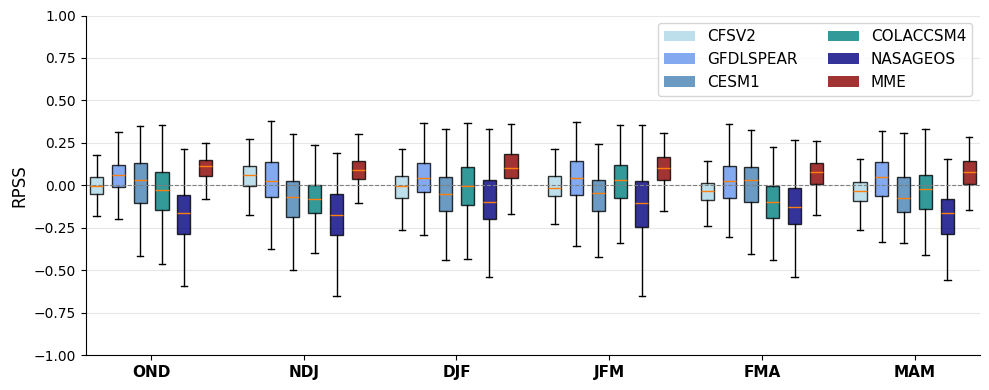

In [38]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
seasons = ['NDJ','DJF','JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','ASO','SON','OND']

selected_seasons = ['OND','NDJ','DJF','JFM','FMA','MAM']



# Store RPSS values for boxplots
boxplot_data = {season: {model: [] for model in model_rpss.keys()}
                for season in selected_seasons}

LEAD = 2

# --- Collect RPSS values per model and season ---
for model in model_rpss.keys():
    rpss_da = model_rpss[model]

    for s_month in range(1, 13):      # forecast start month
        # target season = (start + lead)
        t_month = (s_month + LEAD) % 12
        if t_month == 0:
            t_month = 12
        season_name = seasons[t_month - 1]

        if season_name not in selected_seasons:
            continue

        # get RPSS map
        rpss_map = rpss_da.sel(Smonth=s_month).isel(L=0)

        # flatten, drop nans
        vals = rpss_map.values.flatten()
        vals = vals[~np.isnan(vals)]

        # store
        boxplot_data[season_name][model].extend(vals.tolist())

# --- Create Boxplot Figure ---
models = list(model_rpss.keys())
n_models = len(models)
n_seasons = len(selected_seasons)

fig, ax = plt.subplots(figsize=(10, 4))

positions = []
data_to_plot = []
colors = plt.cm.tab10(np.linspace(0, 1, n_models))
model_colors = {m: colors[i] for i, m in enumerate(models)}

for s_idx, season in enumerate(selected_seasons):
    for m_idx, model in enumerate(models):
        pos = s_idx * (n_models + 1) + m_idx
        positions.append(pos)
        data_to_plot.append(boxplot_data[season][model])

# Draw boxplot
bp = ax.boxplot(
    data_to_plot, positions=positions,
    widths=0.6, patch_artist=True, showfliers=False
)

# Nice color scheme
nature_colors = ['lightblue','cornflowerblue','steelblue','teal','navy','darkred']
model_colors = {m: nature_colors[i % len(nature_colors)] for i, m in enumerate(models)}

# Color boxes
for patch, pos in zip(bp['boxes'], positions):
    m_idx = pos % (n_models + 1)
    if m_idx < n_models:
        model = models[m_idx]
        patch.set_facecolor(model_colors[model])
        patch.set_alpha(0.8)

# X labels
xticks = [i*(n_models+1)+(n_models-1)/2 for i in range(n_seasons)]
ax.set_xticks(xticks)
ax.set_xticklabels(selected_seasons, fontsize=11, fontweight='bold')

# Formatting
ax.set_ylabel('RPSS', fontsize=12)
ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim([-1, 1])

# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1,facecolor=model_colors[m],alpha=0.8,label=m.upper())
    for m in models
]
ax.legend(handles=legend_elements, ncol=2, fontsize=11, loc='best')

sns.despine()
plt.tight_layout()
plt.savefig("figures/rpss_boxplot_members.pdf", dpi=300)
plt.show()
plt.close()
